# Transfer Learning

Utilizing VGG16 pretrained convolutional layers to build a classical art classifier.

----------
Zach Wolpe

www.zachwolpe.com

----------

In [3]:
import pandas as pd
import numpy as np
import os

# data location
loc = '/Users/zachwolpe/Desktop/Artificial Intelligence/pythonProject/Project/datasets/best-artworks-of-all-time/images/images'

# artists of interest
artists = ['Alfred_Sisley', 'Albrecht_Dürer', 'Rembrandt']
art_vals = [1, 2, 3]

In [4]:
# ----- create dataset: paths -----x
dataset = pd.DataFrame(columns=['path', 'artist', 'y'])
for i in range(len(artists)):
    # each artist
    art = artists[i]
    vals = art_vals[i]
    curr_dir = loc + '/' + art
    paintings = os.listdir(curr_dir)
    for p in paintings:
        # for each painting
        dataset = dataset.append(pd.DataFrame([[art + '/' + p, art, vals]], columns=['path', 'artist', 'y']),
                                 ignore_index=True)

# View the Data

First, let's view the data & build some intuition about how our discriminator might be able to model discrepancies between classes.

The function below displays randomly chosen images from each class (artist). One should note that the artist poses substantially different styles & as such after sufficient effective dimensionality reduction via convolution a neural net should be able to separate the data.

Run the below block many time to see different examples - some more homogenous than others - however in general their styles persist in the dataset.

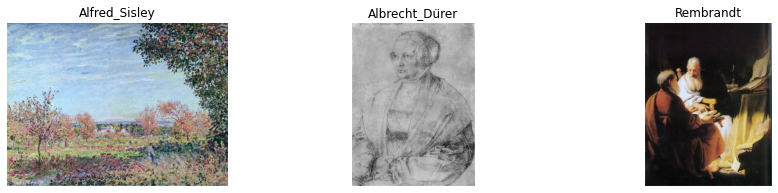

In [5]:
# ---------------------------------------------- view random image ----------------------------------------------x

rand_images = pd.DataFrame(columns=['path', 'artist', 'y'])
for i in art_vals:
    rand_images = rand_images.append(dataset[dataset['y'] == i].sample(1))


import matplotlib.image as img
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for i in range(len(rand_images)):
    path = os.path.join(loc, rand_images.iloc[i, 0])
    ax[i].imshow(img.imread(path))
    ax[i].set_title(rand_images.iloc[i, 1])
    ax[i].axis('off')


## Prepare the Data

Now we relocate the required datasets \& split them into train-test-validation sets to aim our analysis. Thereafter we define a PyTorch data loader in order to:

    - efficently & stochastically load batches of training/testing/validation 
    - transform & process the data on loading 
    
Our data loader comprises of $3$ a unique loader of each train/test \& validation set. The test \& validation sets crop the images to the appropriate $(3, 224, 224)$ dimensions required by $VGG-16$ as well as converts the data to the require _torch.tensor_ class. 

The training set loader performs the same tasks, but additionally to increase generalization, we perform some basic data augmentation by randomly flipping some traning samples - an attempt to learn spactial invarance around identical concepts/samples.

The test & validation sets also crop the image by a pixel to reduce superfluous information.

In [6]:
# ---------------------------------------------- Relocate Data ----------------------------------------------x
import shutil

loc = '/Users/zachwolpe/Desktop/Artificial Intelligence/pythonProject/Project/datasets/best-artworks-of-all-time/images/images'
loc2 = '/Users/zachwolpe/Desktop/Artificial Intelligence/pythonProject/Project/datasets/final'
if os.path.exists(loc2):
    shutil.rmtree(loc2)
for art in artists:
    shutil.copytree(loc + '/' + art, loc2 + '/' + art)
    

# ------------------------------------------ Train Test Val split data -----------------------------------------x
import splitfolders

loc = '/Users/zachwolpe/Desktop/Artificial Intelligence/pythonProject/Project/datasets/final'
loc2 = '/Users/zachwolpe/Desktop/Artificial Intelligence/pythonProject/Project/datasets/final_split'
if os.path.exists(loc2):
    shutil.rmtree(loc2)
splitfolders.ratio(loc, output=loc2, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else:
    print('no GPU == no CUDA :(')

no GPU == no CUDA :(


In [9]:
# ---------------------------------------------- Data Loader ----------------------------------------------x
import random
import torch
import torchvision
import torchvision.transforms as transforms

data_dir = loc2
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True # , num_workers=4 GPU!!!!
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print('------------------------------------------------')
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)


# ---- number samples per class ----x
print('------------------------------------------------')
def artist_count(artist):
    for art in artist:
        n_samples = np.array(dataset[['artist']] == art).flatten().sum()
        print(art, ':', n_samples)
artist_count(image_datasets[TRAIN].classes)

Loaded 678 images under train
Loaded 83 images under val
Loaded 88 images under test
------------------------------------------------
Classes: 
['Albrecht_Dürer', 'Alfred_Sisley', 'Rembrandt']
------------------------------------------------
Albrecht_Dürer : 328
Alfred_Sisley : 259
Rembrandt : 262


# Examine the data

There are $678$ samples in the training set, $83$ and $88$ in the validation & test sets respectivitely. Across the three sets the data is not perfectly balanced, however not sufficiently imbalanced to yield concern. More specifically:

 - Albrecht_Dürer : 328
 - Alfred_Sisley : 259
 - Rembrandt : 262


after processing: 


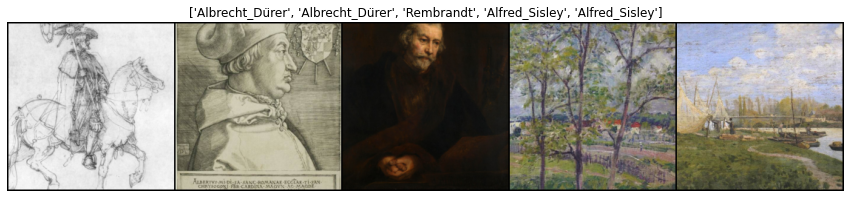

In [33]:
# ---------------------------------------------- Utility Functions ----------------------------------------------x
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# view 
print('after processing: ')
inputs, classes = next(iter(dataloaders[TRAIN]))
classes = classes[:5]
inputs = inputs[:5]
show_databatch(inputs, classes)

# Helper Function

Here we define a two helper functions that allow us to efficiently analyse our classfiers performance - which we'll call before & after training.

In [40]:
# ---------------------------------------------- Visualize Model ----------------------------------------------x
def visualize_model(vgg, num_images=3):
    was_training = vgg.training
    print()


    # Set model for evaluation
    vgg.train(False)
    vgg.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]

        print("Ground truth:")
        # print([class_names[x] for x in labels.data.cpu()])
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        # print([class_names[x] for x in predicted_labels])
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    vgg.train(mode=was_training) # Revert model back to original training state


# ------------------------------------------ Evaluate Accuracy of Test Set ------------------------------------------x
def evaluate_model(vgg, criterion):

    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    print()
    print('____________________ Evaluating Model: _____________________')
    test_batches


    # init empty lists: 1 for each class
    accuracy_per_class = [[] for i in artists]


    for i, data in enumerate(dataloaders[TEST]):

        # deactive training mode
        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        # GPU
        if use_gpu: inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: inputs, labels = Variable(inputs), Variable(labels)

        # Predict + loss 
        outputs = vgg(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)


        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)


        # store results per class 
        for l in range(len(labels)):
            accuracy_per_class[labels[l]].append(preds[l] == labels[l])

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()


    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print('___' * 20)
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print('___' * 20)
    print()
    print("Avg loss (testset): {:.4f}".format(avg_loss))
    print("Avg acc (testset) : {:.4f}".format(avg_acc))
    print('___' * 20)
    print()
    # compute acc per class    
    acc = [(torch.stack(cl)*1.0).mean() for cl in accuracy_per_class]

    print('Accuracy per Class:')
    print('___' * 20)
    print()
    for ac in range(len(acc)):
        print(artists[ac], ':', np.around(acc[ac].item(), 5))

    print('___' * 20)
    print()
    print()

# Model 

### Model Adaptation

We load the $VGG-16$ pretrained model available in pytorch torchvision package.

The convolutional layers are pretrained to extract features, some theoretical results indicate that different layers in a ConvNet learn different levels of abstraction. It's for the reason that we are able to simply 'copy-paste' a ConvNet for a new model.

The VGG-16 is able to classify 1000 different labels = we only need $3$ (one for each artist). To achieve this we simple replace the last layer of the classifer with one with the desired dimensionality (mapping to the number of classes).

Again we only wish to train the linear (fully connected) layers, to disable the training for the convolutional layers we use the setting:

 - requre_grad = False
 
Which will prevent the training loop from computing the gradients w.r.t, as well as prohibit updating these parameters.

Once these adjustments have been made, we visual the model architecture. Which consists of a number pretrained convolutional layers - too effectively process the images and abstract features from the data - & $3$ linear fully connected layers (the first two followed by non-linear activations & dropout layers) used to classify the data.


## Feature Extraction

Since we do not train these layers, we simple rely on $VGG-16$ to effectively extract features from the images. One would hope that the convolutional layers can greatly improve the signal-to-noise ratio before training the classifier.

## Classification

Once the features are extracted by $VGG-16$ - reducing the effective degrees of freedom substantially - the hope is that we can train our model to classify these simpler representations into their classes.

$ReLU$ activations are used in order to learn nonlinearities in the dataset. $Dropout$ layers are used to randomly kill a portion of the nodes in training - a technique to improve generalization by preventing the model from overfitting & simple copying the training set.

In [41]:
# ---------------------------------------------- Model ----------------------------------------------x
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
# vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 3 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256


Test before training...


____________________ Evaluating Model: _____________________

____________________________________________________________

Evaluation completed in 0m 35s
____________________________________________________________

Avg loss (testset): 0.1370
Avg acc (testset) : 0.3864
____________________________________________________________

Accuracy per Class:
____________________________________________________________

Alfred_Sisley : 1.0
Albrecht_Dürer : 0.0
Rembrandt : 0.0
____________________________________________________________



Ground truth:


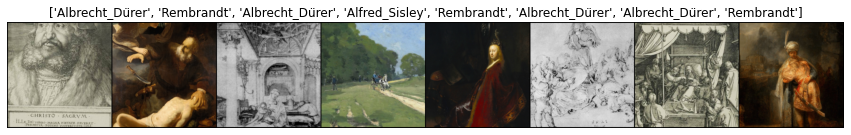

Prediction:


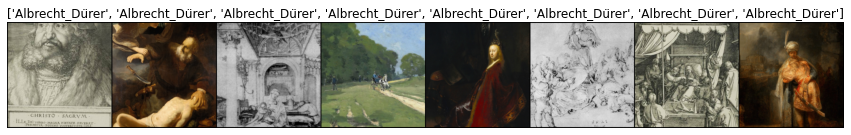

In [43]:
# ------------------------------------------- Results: Before Training -------------------------------------------x

# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

print()
print("Test before training...")
print()

if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# eval before training
evaluate_model(vgg16, criterion)

#test before training
visualize_model(vgg16, num_images=1)

As expected, the results are random, arbitrarily allocated a any class - often the same class.

# Training

Below we define a function for training the parameters of the network, however I will do execute this function as I have pretrained the model.

In [44]:
# ---------------------------------------------- Finally: Training ----------------------------------------------x
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # loss_train += loss.data[0]
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()

        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            # loss_val += loss.data[0]
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg


save_loc = '/Users/zachwolpe/Desktop/Artificial Intelligence/pythonProject/Project/model/'
if not os.path.exists(save_loc):
    os.mkdir(save_loc)
    
    
# ------- Train the Model -------x
# vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
# torch.save(vgg16.state_dict(), save_loc + 'VGG16_v2.pt')

-----------

# Training Complete 

As mensioned, I have already trained the model. As such I'll reload the model parameters.


Test after training...


____________________ Evaluating Model: _____________________

____________________________________________________________

Evaluation completed in 0m 34s
____________________________________________________________

Avg loss (testset): 0.0215
Avg acc (testset) : 0.9318
____________________________________________________________

Accuracy per Class:
____________________________________________________________

Alfred_Sisley : 0.94118
Albrecht_Dürer : 0.88889
Rembrandt : 0.96296
____________________________________________________________



Ground truth:


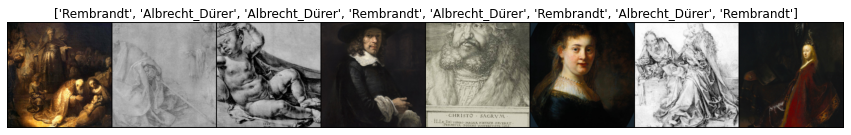

Prediction:


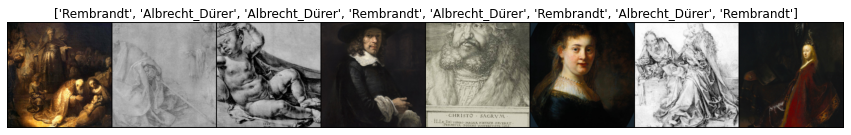

Ground truth:


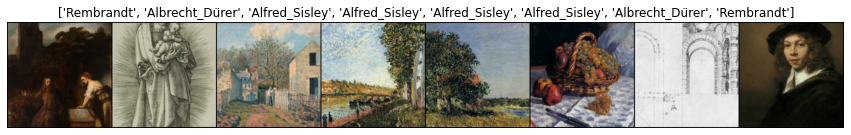

Prediction:


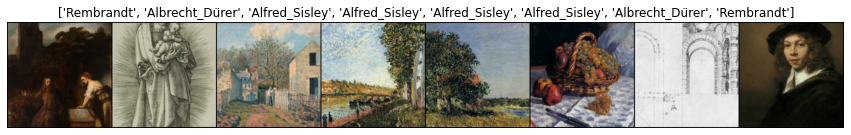

In [47]:
# ---------------------------------------------- Model ----------------------------------------------x
# # Load the pretrained model from pytorch
# vgg16 = models.vgg16_bn()
# # vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))

# # Freeze training for all layers
# for param in vgg16.features.parameters():
#     param.require_grad = False

# # Newly created modules have require_grad=True by default
# num_features = vgg16.classifier[6].in_features
# features = list(vgg16.classifier.children())[:-1] 
# features.extend([nn.Linear(num_features, len(class_names))])
# vgg16.classifier = nn.Sequential(*features) 


# ----- load weights: trained model -----x
vgg16.load_state_dict(torch.load("./model/VGG16_artist.pt"))
criterion = nn.CrossEntropyLoss()

# ------------------------------ Model evaluation and visualization (after training) --------------------------------x

print()
print("Test after training...")
print()

evaluate_model(vgg16, criterion)
visualize_model(vgg16, num_images=10)

-------------
-------------

# Conclusion 

With over $88\%$ in every (test) class, the model appears to adequtely seperate the data. Yay! A next step would be to use sophisticated regularization techniques (though we have utilized dropout & a seperate testset that bares no consequence of the parameter tuning process) & extend the model to more artists - this dataset is intuitively seperable given the distinct styles of each artist, additional experimentation struggled when including _Picasso_ & _Salvidor Dali_ - both of whom possess a more eclectic range of styles.

One might also wish to construct a simpler lower dimensional manifold to represent the data - we explore this elsewhere in the module project.